## Temporal Convolution Network (TCN) for predictive maintenance of aircraft engines

### Data
Use the `TurboFan` class in `datasets.turbofan` to download and pre-process the turbofan dataset.  

In [1]:
# add aidc-2018-timeseries to notebook path
import sys
sys.path.append("../")
%matplotlib inline

In [2]:
from datasets.turbofan import TurboFan

# dataset configuration
data_dir = "./"  # Location to download data to
seq_len = 50     # Sequence length of samples in final processed dataset
skip = 1         # Number of time-points between adjacent windows
max_rul = 130    # Value at which the 'y' variable is capped

# create dataset
turbofan_dataset = TurboFan(data_dir=data_dir, T=seq_len, skip=skip, max_rul_predictable=max_rul,
                            recurrent_axis_name='W', feature_axis_name='C', label_axis_name='Fo')

Loading data
Creating sliding window data
Done. Number of samples in train: 160854, number of samples in test: 707


Call the `plot_sample` method of the dataset object to visualize a sample set of readings from the dataset

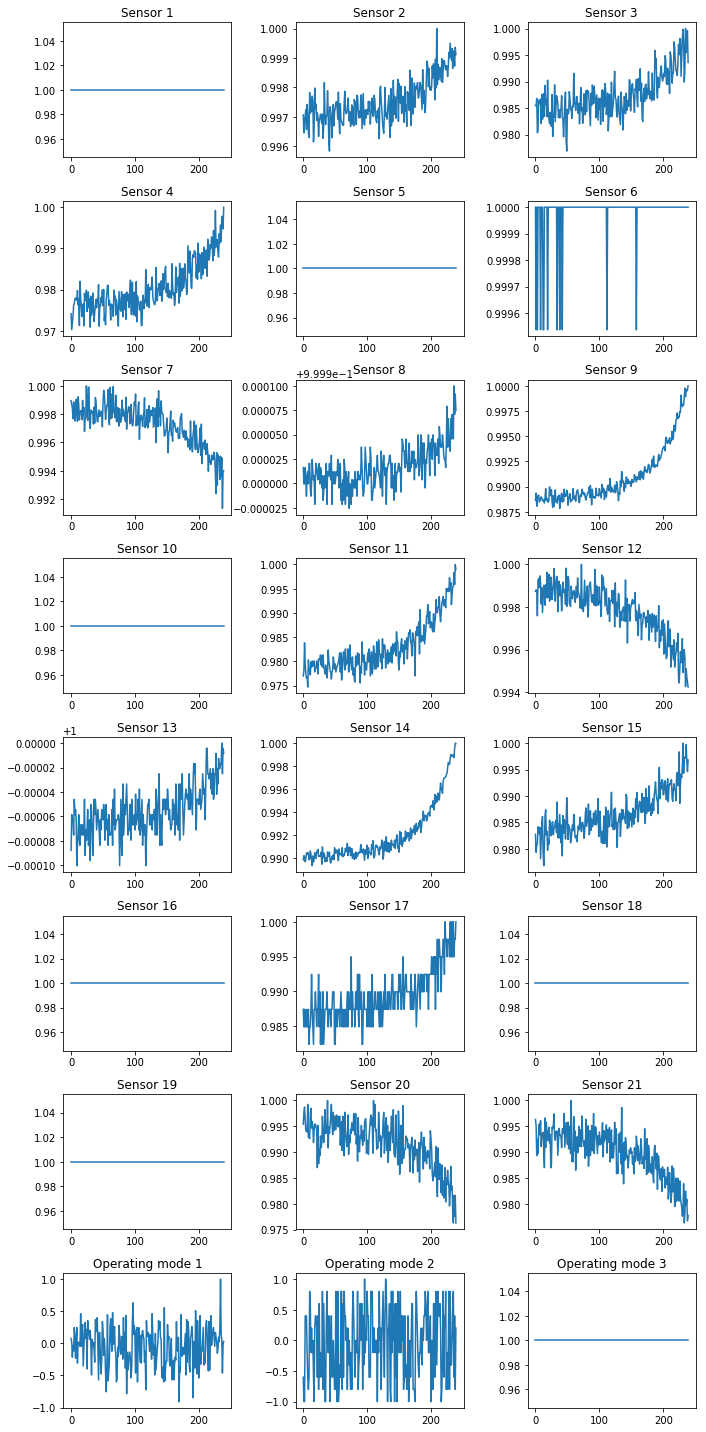

<Figure size 432x288 with 0 Axes>

In [3]:
out_folder = "./"  # Folder to write images to
turbofan_dataset.plot_sample(out_folder, trajectory_id=10)

### Create a data loader in ngraph-neon

In [4]:
from ngraph.frontends.neon import ArrayIterator

batch_size = 128
num_iterations = 10000

train_iterator = ArrayIterator(turbofan_dataset.train,
                               batch_size,
                               total_iterations=num_iterations,
                               shuffle=True)
val_iterator = ArrayIterator(turbofan_dataset.test, batch_size)

### Define placeholders
First, we need to define placeholders; these will be used to feed data into the model in batches.
`Axes` are a unique feature of ngraph; they are composed of `Axis` objects which are named dimensions that are matched by name instead of by ordering.
Individual `Axis` can be named arbitrarily, though ngraph provides conventions for the batch axis (`'N'`) as 
well as the time axis in recurrent models and channel and spatial axes in convolutional models.


(Typically, the time axis in ngraph is called `'REC'` (recurrent) but because we are using a convolutional model
to process time series data, the time axis maps to the `'W'` axis, and the feature axis corresponds to `'C'`, the
convolution channels.)

In [5]:
import ngraph as ng

# number of input and output features  
n_features = turbofan_dataset.train['X']['data'].shape[2] # read off the number of features in the input data
n_output_features = 1

# name and create axes
batch_axis = ng.make_axis(length=batch_size, name="N")
time_axis = ng.make_axis(length=seq_len, name="W")
feature_axis = ng.make_axis(length=n_features, name="C")
out_axis = ng.make_axis(length=n_output_features, name="Fo")

in_axes = ng.make_axes([batch_axis, time_axis, feature_axis])
out_axes = ng.make_axes([batch_axis, out_axis])

# build placeholders for the created axes
inputs = dict(X=ng.placeholder(in_axes), 
              y=ng.placeholder(out_axes))

### Build TCN Model

The TCN model consists of residual blocks of which contain dilated convolutional layers, weight normalization, relu activations, and spatial dropout. Let's build a model with a single residual block.

<table class="image">
<caption align="bottom">Residual block</caption>
<tr><img src='img/residual_block.png' alt='residual block' width='250'></tr></table>
Bai et al "An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling"

Let's first build the main path of the residual block. 
We create two convolution and dropout layers, and wrap them in a `Sequential` container.
`Sequential` takes a list of neon layers or callables. [termininology]
Calling a `Sequential` object will cause each of the layers to be called in order.

In [6]:
from topologies.custom_neon_classes import Dropout2D, DilatedCausalConv
from ngraph.frontends.neon import GaussianInit, Rectlin, Sequential

kernel_size = 5  # conv kernel size
n_filters = 50   # number of filters per conv layer
dilation = 1     # conv dilation
dropout = 0.2    # dropout rate
keep = 1 - dropout  # ratio to keep

layers = []

for i in range(2):
    
    # causal conv, weight norm, relu
    layers += [DilatedCausalConv(filter_shape=(kernel_size, n_filters),
                                 padding='causal',
                                 dilation=dilation,
                                 strides=1,
                                 activation=Rectlin(),
                                 filter_init=GaussianInit(0, 0.01), 
                                 batch_norm=False)]

    # spatial dropout
    layers += [Dropout2D(keep)]

# combine layers in a Sequential container
main_path = Sequential(layers)

Now for the side path: this is the residual path. 
If the number of input channels and output channels of the main path are the same, the residual path passes the input, unmodified, to be added to the output of the main path.
Otherwise, it uses 1-dimensional convolutions to ensure that the main and residual paths have the same number of output channels (`n_filters`).

In [7]:
from ngraph.frontends.neon import Convolution

side_path = Sequential([Convolution(filter_shape=(1, n_filters),
                                    filter_init=GaussianInit(0, 0.01),
                                    strides=1,
                                    dilation=1,
                                    padding='same',
                                    batch_norm=False)])

Bring the two paths together using the `ResidualModule` API:

In [8]:
from ngraph.frontends.neon.model import ResidualModule

res_block = ResidualModule(main_path, side_path)

We can combine the code from the last three cells into a factory function that creates residual blocks:

In [9]:
from ngraph.frontends.neon import Convolution
from ngraph.frontends.neon import GaussianInit, Rectlin, Sequential
from ngraph.frontends.neon.model import ResidualModule
from topologies.custom_neon_classes import Dropout2D, DilatedCausalConv


def residual_block(kernel_size, n_filters, dilation, dropout, res_path_conv=False):

    keep = 1 - dropout
    
    # main path
    layers = []
    for i in range(2):

        # causal conv, weight norm, relu
        layers += [DilatedCausalConv(filter_shape=(kernel_size, n_filters),
                                     padding='causal',
                                     dilation=dilation,
                                     strides=1,
                                     activation=Rectlin(),
                                     filter_init=GaussianInit(0, 0.01), 
                                     batch_norm=False)]

        # spatial dropout  
        layers += [Dropout2D(keep)]

    # combine layers in a Sequential container
    main_path = Sequential(layers)
    
    # side path
    if res_path_conv:
        side_path = Sequential([Convolution(filter_shape=(1, n_filters),
                                            filter_init=GaussianInit(0, 0.01),
                                            strides=1,
                                            dilation=1,
                                            padding='same',
                                            batch_norm=False)])
    else:
        side_path = None
        
    # residual block
    res_block = ResidualModule(main_path, side_path)
    
    return res_block

Now build a TCN with a stack of residual blocks, where the convolutional layers in each block have the same number of filters. The first residual block will have 1-D convolutions in the residual path but the subsequent blocks will will not. Here we define the TCN layers:

In [10]:
kernel_size = 4  # conv kernel size
n_filters = 50   # number of filters per conv layer
dropout = 0.1    # dropout rate

num_blocks = 4   # number of residual blocks

layers = []
for i in range(num_blocks):
    
    dilation = 2 ** i
    
    res_path_conv = True if i == 0 else False
    layers += [residual_block(kernel_size, n_filters, dilation, dropout, res_path_conv)]
    layers += [Rectlin()]
        
tcn = Sequential(layers)

Note that the output of the TCN has the same sequence length as its input; 
however due to dilation of the convolution filters, the "receptive field" of each time-point in the output is much larger. 
Each time-point operates on multiple past time-points. 
If the network is deep enough, the last time-point has sufficiently large receptive field that its use alone will suffice to generate the output. 

<table class="image">
<caption>Dilated convolution (3 layers)</caption>
<tr><img src='img/dilated_conv.png' alt='dilated convolution' height='120'></tr></table>
Bai et al "An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling"

We can read off the last time-point as follows:

In [11]:
def last_timepoint(op):
    # select the last timepoint of the Axis named "W"
    slices = [slice(seq_len-1, seq_len, 1) if ax.name == "W" else slice(None) for ax in op.axes]
    return ng.tensor_slice(op, slices)

Use an `Affine` layer to predict the RUL from the last time-point:

In [12]:
from ngraph.frontends.neon.layer import Affine

affine_layer = Affine(axes=out_axis, weight_init=GaussianInit(0, 0.01), activation=Rectlin())

Finally, encapsulate the entire model in a `Sequential` container. 

In [13]:
model = Sequential([tcn, 
                    last_timepoint, 
                    affine_layer])

### Specify training loss, validation loss, and optimizer

Forward propagation through the defined model, on the input placeholder defined above:

In [14]:
prediction_train = model(inputs['X'])  # model output

Define the training loss as the Mean Squared Error (MSE) between model output `y_hat` and label placeholder:

In [15]:
train_loss = ng.squared_L2(prediction_train - inputs['y'])

Similarly, with `Layer.inference_mode_on()`, define the MSE for validation data:

In [16]:
from ngraph.frontends.neon import Layer

with Layer.inference_mode_on():
    prediction_val = model(inputs['X'])
    
eval_loss = ng.mean(ng.squared_L2(prediction_val - inputs['y']), out_axes=())

Define the optimizer:

In [17]:
from ngraph.frontends.neon import Adam

lr = 0.002                # learning rate
grad_clip_value = 0.4     # gradient clip value

optimizer = Adam(learning_rate=lr, gradient_clip_value=grad_clip_value)

Here we call the `optimizer`, which causes gradients to be computed and trainable parameters to be updated. 
We also compute the average minibatch training loss. 
Note that these two operations are combined into a single, ordered operation using `ng.sequential`:

In [18]:
batch_cost = ng.sequential([optimizer(train_loss), 
                            ng.mean(train_loss, out_axes=())])

Create the train and validation computations:

In [19]:
train_computation = ng.computation(batch_cost, "all") 
eval_computation = ng.computation(eval_loss, "all")

### Tensorboard visualization

ngraph supports Tensorboard for visualization. 
The code below will cause a directory `tensorboard` to be created in the current directory,
and a subdirectory within `tensorboard` named with the current timestamp, e.g. `180521T170237`.

In [20]:
from ngraph.op_graph.tensorboard.tensorboard import TensorBoard

tensorboard_dir = "./tensorboard/"  # directory to save tensorboard summaries to

# create tensorboard object 
tb = TensorBoard(tensorboard_dir)

# add model graph for visualization
tb.add_graph(model)

To start tensorboard open a terminal and type the commands below.
(Remember to replace the timestamp directory name with what you see in the local `tensorboard` directory.)
Open a browser window and navigate to the URL printed in the terminal.

```
cd aidc-2918-timeseries
. .venv/bin/activate
tensorboard --logdir=./tutorials/tensorboard/180521T170237
```

### Training the model

Finally, model training:

In [ ]:
import ngraph.transformers as ngt
from contextlib import closing

train_iterator.reset()  # not necessary the first time train loop is run

# Now bind the computations we are interested in
with closing(ngt.make_transformer()) as transformer:
    
    # compile computations
    train_function = transformer.add_computation(train_computation)
    eval_function = transformer.add_computation(eval_computation)
    
    # train loop
    for step, data in enumerate(train_iterator):

        # construct feed dictionary of inputs to train function
        feed_dict = {inputs["X"]: data["X"], inputs["y"]: data["y"]}
        
        # Mean batch cost
        output = train_function(feed_dict=feed_dict)
        train_loss = output[()].item()
        tb.add_scalar("train_loss", train_loss, step=step)
        
        # Every N iterations print test set metrics
        if step % 100 == 0 and step > 0:

            # calculate metrics over test set
            avg_eval_loss = 0.0
            val_iterator.reset()
            for e, data_test in enumerate(val_iterator):
                feed_dict_test = {inputs["X"]: data_test["X"], inputs["y"]: data_test["y"]}
                eval_loss = eval_function(feed_dict=feed_dict_test)
                avg_eval_loss += eval_loss

            avg_eval_loss /= (e + 1)
            tb.add_scalar("eval_loss", avg_eval_loss, step=step)
            
            print("%d Train Loss: %4.2f, Validation Loss: %4.2f" % (step, train_loss, avg_eval_loss))

100 Train Loss: 2668.38, Validation Loss: 1974.23
200 Train Loss: 2086.71, Validation Loss: 2388.20
300 Train Loss: 1790.47, Validation Loss: 2261.98
400 Train Loss: 1606.36, Validation Loss: 1802.33
500 Train Loss: 2552.10, Validation Loss: 2871.47
600 Train Loss: 1491.04, Validation Loss: 1446.06
700 Train Loss: 1604.33, Validation Loss: 1497.96
